In [1]:
## dependencies

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy.stats as st
from scipy.stats import linregress
import random

In [2]:
## import base data file and read in dataframe

data_file = "Resources/clean_data2.csv"
data_df = pd.read_csv(data_file)
data_df

,State,County,POP2010,OHU2010,PovertyRate,MedianFamilyIncome,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,...,Years of Potential Life Lost Rate,% Obese,% Fair/Poor,# Diabetics,# Violent Crimes,# Unemployed,% Children in Poverty,Latitude,Longitude,Original Medicare
0,Alabama,Autauga,54571,20221,13.858333,61082.916667,2,2,1,2,...,9158.0,34,18,711.0,145.0,1327.0,19.0,32.534920,-86.642749,5784
1,Alabama,Baldwin,182265,73180,14.358065,60664.935484,3,3,3,2,...,7394.0,27,16,2615.0,415.0,4791.0,20.0,30.660970,-87.749840,28388
2,Alabama,Barbour,27457,9820,24.533333,43123.000000,3,3,1,2,...,8573.0,44,25,525.0,85.0,771.0,45.0,31.869603,-85.393197,4372
3,Alabama,Bibb,22915,7953,16.025000,43362.500000,0,0,0,1,...,11766.0,40,20,333.0,33.0,561.0,29.0,32.998644,-87.126439,2480
4,Alabama,Blount,57322,21578,17.911111,52136.000000,0,0,0,2,...,9333.0,35,19,705.0,123.0,1316.0,22.0,33.980867,-86.567371,6070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,Wyoming,Sweetwater,43806,16475,11.841667,81835.083333,0,0,0,2,...,6878.0,32,16,469.0,159.0,1053.0,10.0,41.659496,-108.879431,5641
3089,Wyoming,Teton,21294,8973,8.100000,89555.250000,0,0,0,0,...,3728.0,13,12,104.0,NaN,558.0,8.0,43.934637,-110.589810,3122
3090,Wyoming,Uinta,21118,7668,14.166667,65312.666667,0,0,0,0,...,7660.0,28,15,243.0,8.0,475.0,12.0,41.287492,-110.547562,2804
3091,Wyoming,Washakie,8533,3492,14.133333,62213.666667,0,1,0,0,...,7294.0,28,14,156.0,7.0,174.0,16.0,43.904997,-107.682861,1812


In [3]:
## investigating data
## find low and high MDI (median family income) 
minMDI = data_df['MedianFamilyIncome'].min()
maxMDI = data_df['MedianFamilyIncome'].max()
print(minMDI)
print(maxMDI)

21623.0
133021.22033898305


In [4]:
# calculate percentages from data df

pct_diab = round((data_df["# Diabetics"]/data_df["POP2010"])*100, 2)
pct_dead = round((data_df["# Deaths"]/data_df["POP2010"])*100, 2)
pct_crime = round((data_df["# Violent Crimes"]/data_df["POP2010"])*100, 2)
pct_unemp = round((data_df["# Unemployed"]/data_df["POP2010"])*100, 2)

#add new columns to data df   
data_df["% Diabetics"] = pct_diab
data_df["% Deaths"] = pct_dead
data_df["% Violent Crimes"] = pct_crime
data_df["% Unemployed"] = pct_unemp


In [5]:
list(data_df.columns.values)

['State',
 'County',
 'POP2010',
 'OHU2010',
 'PovertyRate',
 'MedianFamilyIncome',
 'LILATracts_1And10',
 'LILATracts_halfAnd10',
 'LILATracts_1And20',
 'LILATracts_Vehicle',
 'LAPOP1_10',
 'LAPOP05_10',
 'LAPOP1_20',
 'LALOWI1_10',
 'LALOWI05_10',
 'LALOWI1_20',
 'lapophalf',
 'TractKids',
 'TractSeniors',
 'TractWhite',
 'TractBlack',
 'TractAsian',
 'TractNHOPI',
 'TractAIAN',
 'TractOMultir',
 'TractHispanic',
 'TractHUNV',
 'TractSNAP',
 'Food Environment Index',
 '# Deaths',
 'Years of Potential Life Lost Rate',
 '% Obese',
 '% Fair/Poor',
 '# Diabetics',
 '# Violent Crimes',
 '# Unemployed',
 '% Children in Poverty',
 'Latitude',
 'Longitude',
 'Original Medicare',
 '% Diabetics',
 '% Deaths',
 '% Violent Crimes',
 '% Unemployed']

In [6]:
# identify people in food deserts vs people not.  Per USDA, approximately 10% of census tracts are food
# deserts. We will assume, for simplicity sake, that approximately 10% of our counties are food deserts.  
# So need to get the Food Environment Index (FEI) ratings of the bottom 10% of counties. 
# FEI = Indicator of access to healthy foods - 0 is worst, 10 is best

# First, get df where at least the FEI column is complete: 
FEI_df = data_df.loc[data_df['Food Environment Index'] >= 0, :]

FEI_len = len(FEI_df['Food Environment Index'])
print(f" There are {FEI_len} rows in the dataset. Find bottom 10% and top 90%.")

#sort dataframa by FEI rank
FEI_sort_df = FEI_df.sort_values(by = ['Food Environment Index'], ascending=True)
len10 = int(round((FEI_len * 0.1), -1))
len90 = FEI_len - len10

print(len10)
print(len90)


 There are 3093 rows in the dataset. Find bottom 10% and top 90%.
310
2783


In [7]:
# First, get df where at least the FEI column is complete: 
FEI_df = data_df.loc[data_df['Food Environment Index'] >= 0, :]

FEI_len = len(FEI_df['Food Environment Index'])
print(f" There are {FEI_len} rows in the dataset. Find bottom 10% and top 90%.")

#sort dataframa by FEI rank
FEI_sort_df = FEI_df.sort_values(by = ['Food Environment Index'], ascending=True)
len10 = int(round((FEI_len * 0.1), -1))
len90 = FEI_len - len10

print(len10)
print(len90)


 There are 3093 rows in the dataset. Find bottom 10% and top 90%.
310
2783


In [8]:
# get dataframes representing data for food deserts (FEI_10_df) and non-food deserts (FEI_90_df)
FEI_10_df = FEI_sort_df.tail(310) 
FEI_90_df = FEI_sort_df.head(2782) 

# use these dfs for more in-depth plotting 

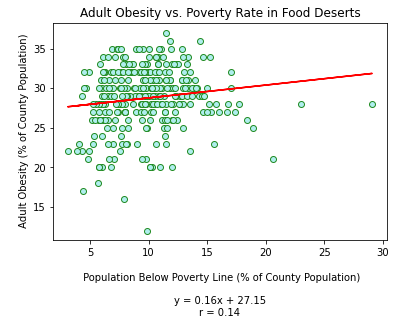

In [9]:
## plot poverty rate% vs %obesity in food desert

## get df with only values that correspond for both series 
plot1_df = FEI_10_df[(pd.notnull(FEI_10_df['PovertyRate'])) & (pd.notnull(FEI_10_df['% Obese']))]


## plot subset of the data - 300 is about 10 to 20 percent
x_axis = plot1_df['PovertyRate']
y_axis = plot1_df['% Obese']

 # parameters for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_axis, regress_values, "r-")

## Calculate the correlation coefficient and linear regression model 
pearsonr = st.pearsonr(x_axis, y_axis)
r_display = str(round(pearsonr[0],2))

## scatter plot
plot1 = plt.scatter(x_axis, y_axis, marker="o", facecolors="paleturquoise", edgecolors="forestgreen")
plt.title(f"Adult Obesity vs. Poverty Rate in Food Deserts")
plt.xlabel("\n Population Below Poverty Line (% of County Population)" + "\n" + "\n" + line_eq + "\n" + "r = " + r_display)
plt.ylabel("\n Adult Obesity (% of County Population)")

fig1A = plt.gcf()
plt.show()
fig1A.savefig("Scatter_Plots/Fig 01A - Obesity_Poverty - FD", dpi=100)


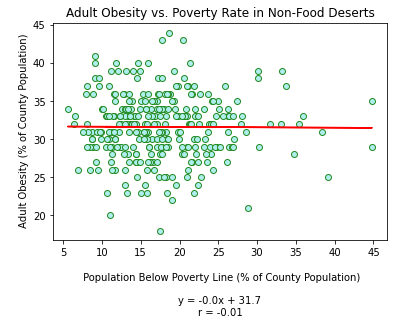

In [10]:
## plot poverty rate% vs %obesity in non-food desert

## get df with only values that correspond for both series 
plot1_df = FEI_90_df[(pd.notnull(FEI_90_df['PovertyRate'])) & (pd.notnull(FEI_90_df['% Obese']))]


## plot subset of the data - 300 is about 10 to 20 percent
subset_size = 300
x_axis = np.random.choice(plot1_df['PovertyRate'], subset_size, replace=False)
y_axis = np.random.choice(plot1_df['% Obese'], subset_size, replace=False)

 # parameters for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_axis, regress_values, "r-")

## Calculate the correlation coefficient and linear regression model 
pearsonr = st.pearsonr(x_axis, y_axis)
r_display = str(round(pearsonr[0],2))

## scatter plot
plot1B = plt.scatter(x_axis, y_axis, marker="o", facecolors="paleturquoise", edgecolors="forestgreen")
plt.title(f"Adult Obesity vs. Poverty Rate in Non-Food Deserts")
plt.xlabel("\n Population Below Poverty Line (% of County Population)" + "\n" + "\n" + line_eq + "\n" + "r = " + r_display)
plt.ylabel("\n Adult Obesity (% of County Population)")

fig1B = plt.gcf()
plt.show()
fig1B.savefig("Scatter_Plots/Fig 01A - Obesity_Poverty Non-FD", dpi=100)


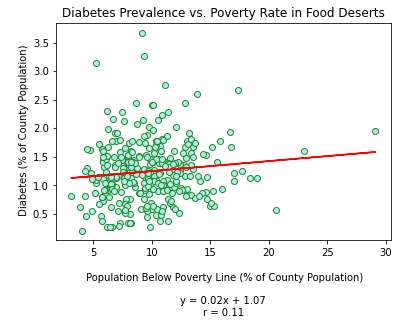

In [11]:
## plot poverty rate% vs %diabetes in food desert

## get df with only values that correspond for both series 
plot1_df = FEI_10_df[(pd.notnull(FEI_10_df['PovertyRate'])) & (pd.notnull(FEI_10_df['% Diabetics']))]


## plot subset of the data - 300 is about 10 to 20 percent
x_axis = plot1_df['PovertyRate']
y_axis = plot1_df['% Diabetics']


## parameters for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_axis, regress_values, "r-")

## Calculate the correlation coefficient and linear regression model 
pearsonr = st.pearsonr(x_axis, y_axis)
r_display = str(round(pearsonr[0],2))

## scatter plot
plot2 = plt.scatter(x_axis, y_axis, marker="o", facecolors="paleturquoise", edgecolors="forestgreen")
plt.title(f"Diabetes Prevalence vs. Poverty Rate in Food Deserts")
plt.xlabel("\n Population Below Poverty Line (% of County Population)" + "\n" + "\n" + line_eq + "\n" + "r = " + r_display)
plt.ylabel("\n Diabetes (% of County Population)")

fig2A = plt.gcf()
plt.show()
fig2A.savefig("Scatter_Plots/Fig 02A - Diabetes_Poverty - FD", dpi=100)


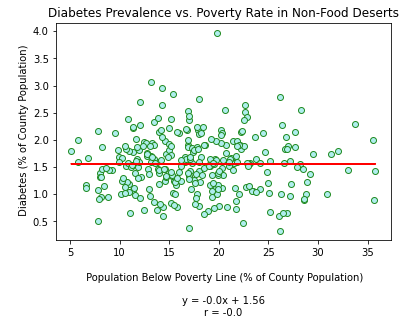

In [12]:
## plot poverty rate% vs %diabetes in non-food desert

## get df with only values that correspond for both series 
plot1_df = FEI_90_df[(pd.notnull(FEI_90_df['PovertyRate'])) & (pd.notnull(FEI_90_df['% Diabetics']))]

## plot subset of the data - 300 is about 10 to 20 percent
subset_size = 300
x_axis = np.random.choice(plot1_df['PovertyRate'], subset_size, replace=False)
y_axis = np.random.choice(plot1_df['% Diabetics'], subset_size, replace=False)

## parameters for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_axis, regress_values, "r-")

## Calculate the correlation coefficient and linear regression model 
pearsonr = st.pearsonr(x_axis, y_axis)
r_display = str(round(pearsonr[0],2))

## scatter plot
plot2 = plt.scatter(x_axis, y_axis, marker="o", facecolors="paleturquoise", edgecolors="forestgreen")
plt.title(f"Diabetes Prevalence vs. Poverty Rate in Non-Food Deserts")
plt.xlabel("\n Population Below Poverty Line (% of County Population)" + "\n" + "\n" + line_eq + "\n" + "r = " + r_display)
plt.ylabel("\n Diabetes (% of County Population)")

fig2B = plt.gcf()
plt.show()
fig2B.savefig("Scatter_Plots/Fig 02A - Diabetes_Poverty - Non-FD", dpi=100)

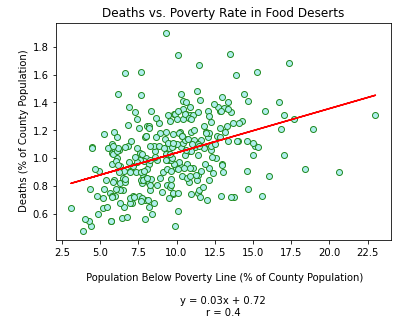

In [13]:
## plot poverty rate% vs %deaths in food desert

## get df with only values that correspond for both series 
plot1_df = FEI_10_df[(pd.notnull(FEI_10_df['PovertyRate'])) & (pd.notnull(FEI_10_df['% Deaths']))]


## plot subset of the data - 300 is about 10 to 20 percent
x_axis = plot1_df['PovertyRate']
y_axis = plot1_df['% Deaths']


## parameters for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_axis, regress_values, "r-")

## Calculate the correlation coefficient and linear regression model 
pearsonr = st.pearsonr(x_axis, y_axis)
r_display = str(round(pearsonr[0],2))

## scatter plot
plot2 = plt.scatter(x_axis, y_axis, marker="o", facecolors="paleturquoise", edgecolors="forestgreen")
plt.title(f"Deaths vs. Poverty Rate in Food Deserts")
plt.xlabel("\n Population Below Poverty Line (% of County Population)" + "\n" + "\n" + line_eq + "\n" + "r = " + r_display)
plt.ylabel("\n Deaths (% of County Population)")

fig3A = plt.gcf()
plt.show()
fig3A.savefig("Scatter_Plots/Fig 03A - Deaths_Poverty - FD", dpi=100)


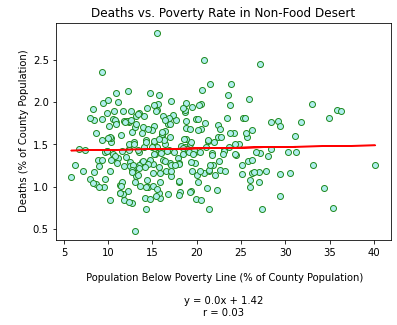

In [14]:
## plot poverty rate% vs %deaths in non-food desert

## get df with only values that correspond for both series 
plot1_df = FEI_90_df[(pd.notnull(FEI_90_df['PovertyRate'])) & (pd.notnull(FEI_90_df['% Deaths']))]


## plot subset of the data - 300 is about 10 to 20 percent
subset_size = 300
x_axis = np.random.choice(plot1_df['PovertyRate'], subset_size, replace=False)
y_axis = np.random.choice(plot1_df['% Deaths'], subset_size, replace=False)

## parameters for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_axis, regress_values, "r-")

## Calculate the correlation coefficient and linear regression model 
pearsonr = st.pearsonr(x_axis, y_axis)
r_display = str(round(pearsonr[0],2))

## scatter plot
plot2 = plt.scatter(x_axis, y_axis, marker="o", facecolors="paleturquoise", edgecolors="forestgreen")
plt.title(f"Deaths vs. Poverty Rate in Non-Food Desert")
plt.xlabel("\n Population Below Poverty Line (% of County Population)" + "\n" + "\n" + line_eq + "\n" + "r = " + r_display)
plt.ylabel("\n Deaths (% of County Population)")

fig3B = plt.gcf()
plt.show()
fig3B.savefig("Scatter_Plots/Fig 03A - Deaths_Poverty - Non-FD", dpi=100)

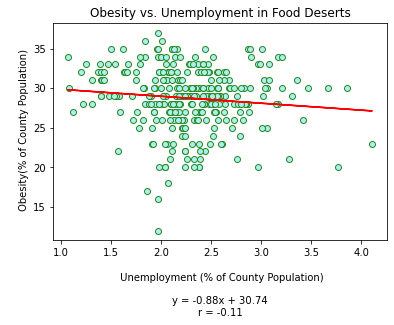

In [16]:
## plot obesety rate% vs unemployment in food desert

## get df with only values that correspond for both series 
plot1_df = FEI_10_df[(pd.notnull(FEI_10_df['% Unemployed'])) & (pd.notnull(FEI_10_df['% Obese']))]


## plot subset of the data - 300 is about 10 to 20 percent
x_axis = plot1_df['% Unemployed']
y_axis = plot1_df['% Obese']


## parameters for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_axis, regress_values, "r-")

## Calculate the correlation coefficient and linear regression model 
pearsonr = st.pearsonr(x_axis, y_axis)
r_display = str(round(pearsonr[0],2))

## scatter plot
plot2 = plt.scatter(x_axis, y_axis, marker="o", facecolors="paleturquoise", edgecolors="forestgreen")
plt.title(f"Obesity vs. Unemployment in Food Deserts")
plt.xlabel("\n Unemployment (% of County Population)" + "\n" + "\n" + line_eq + "\n" + "r = " + r_display)
plt.ylabel("\n Obesity(% of County Population)")

fig4A = plt.gcf()
plt.show()
fig4A.savefig("Scatter_Plots/Fig 04A - Obesity_Unemp - FD", dpi=100)


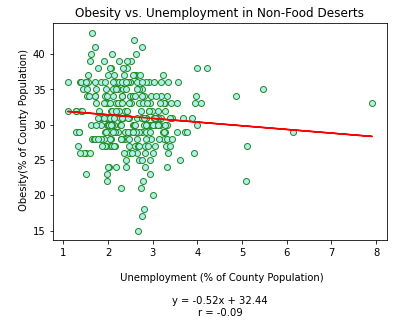

In [17]:
## plot obesety rate% vs unemployment in non-food desert

## get df with only values that correspond for both series 
plot1_df = FEI_90_df[(pd.notnull(FEI_90_df['% Unemployed'])) & (pd.notnull(FEI_90_df['% Obese']))]


subset_size = 300
x_axis = np.random.choice(plot1_df['% Unemployed'], subset_size, replace=False)
y_axis = np.random.choice(plot1_df['% Obese'], subset_size, replace=False)


## parameters for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_axis, regress_values, "r-")

## Calculate the correlation coefficient and linear regression model 
pearsonr = st.pearsonr(x_axis, y_axis)
r_display = str(round(pearsonr[0],2))

## scatter plot
plot2 = plt.scatter(x_axis, y_axis, marker="o", facecolors="paleturquoise", edgecolors="forestgreen")
plt.title(f"Obesity vs. Unemployment in Non-Food Deserts")
plt.xlabel("\n Unemployment (% of County Population)" + "\n" + "\n" + line_eq + "\n" + "r = " + r_display)
plt.ylabel("\n Obesity(% of County Population)")

fig4B = plt.gcf()
plt.show()
fig4B.savefig("Scatter_Plots/Fig 04B - Obesity_Unemp - Non-FD", dpi=100)

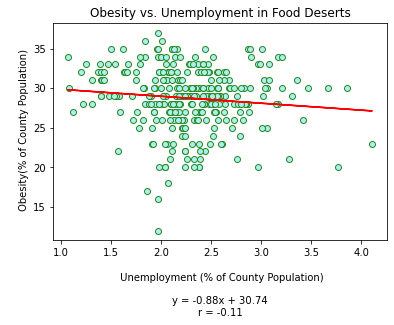

In [19]:
## plot number unempl rate% vs unemployment in food desert

## get df with only values that correspond for both series 
plot1_df = FEI_10_df[(pd.notnull(FEI_10_df['% Unemployed'])) & (pd.notnull(FEI_10_df['% Obese']))]


## plot subset of the data - 300 is about 10 to 20 percent
x_axis = plot1_df['% Unemployed']
y_axis = plot1_df['% Obese']


## parameters for linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_axis, regress_values, "r-")

## Calculate the correlation coefficient and linear regression model 
pearsonr = st.pearsonr(x_axis, y_axis)
r_display = str(round(pearsonr[0],2))

## scatter plot
plot2 = plt.scatter(x_axis, y_axis, marker="o", facecolors="paleturquoise", edgecolors="forestgreen")
plt.title(f"Obesity vs. Unemployment in Food Deserts")
plt.xlabel("\n Unemployment (% of County Population)" + "\n" + "\n" + line_eq + "\n" + "r = " + r_display)
plt.ylabel("\n Obesity(% of County Population)")

fig4A = plt.gcf()
plt.show()
fig4A.savefig("Scatter_Plots/Fig 04A - Obesity_Unemp - FD", dpi=100)


In [ ]:
## plot TractSNAP vs. %obesity, #diabestes enrollment, and #deaths

In [ ]:
## plot poverty rate% vs food environment index

In [ ]:
## plot #unemployed vs. #violent crimes

In [ ]:
##decided to ditch this approach - too complicated

## Group data by income levels to start. 
## 26,200, assuming a 4-person household under the national poverty limit
## 30,160, assuming a 4-person household, each earner making national minimum wage; 
## 30,160, assuming a 4-person household, each earner making national minimum wage; 
## and incrementally higher salaries per 4-person (2-earner) household: 45,000, 70,000, 100,000, 150,000 

# df_income = data_df.loc[((data_df["Temp (F)"] > 70) & (weather_df["Temp (F)"] < 80))
#                           & (weather_df["Wind Speed (mph)"] < 10)
#                           & (weather_df["Cloudiness (%)"] == 0), :]

# df_income_pov = data_df.loc[data_df['MedianFamilyIncome'] <= 26200, :]
# df_income_mw = data_df.loc[(data_df['MedianFamilyIncome'] > 26200) & 
#                            (data_df['MedianFamilyIncome'] <= 30160), :]
# df_income45 = data_df.loc[(data_df['MedianFamilyIncome'] > 30160) & 
#                            (data_df['MedianFamilyIncome'] <= 45000), :]
# df_income70 = data_df.loc[(data_df['MedianFamilyIncome'] > 45000) & 
#                            (data_df['MedianFamilyIncome'] <= 70000), :]
# df_income100 = data_df.loc[(data_df['MedianFamilyIncome'] > 70000) & 
#                            (data_df['MedianFamilyIncome'] <= 100000), :] 
# df_income150 = data_df.loc[(data_df['MedianFamilyIncome'] > 100000) & 
#                            (data_df['MedianFamilyIncome'] <= 150000), :] 
